In [1]:
import jax.numpy as jnp
import diffrax
import jax
jax.config.update('jax_enable_x64',True)

from jax.random import key
import matplotlib.pyplot as plt

In [ ]:
def H(q,p):
    return (
        0.5 * (jnp.sum(p**2) +jnp.sum(q**2))
        +q[0]**2*q[1] - (1/3) * q[1]**3
	)

def simulate_hamiltonian(
	H,
	q0,
	p0,
	T = 40.,
	t0 = 0.,
	dt0 = 0.005
	):
	def f(t,state,args=None):
		p = state['p']
		q = state['q']
		qdot = jax.grad(H,argnums = 1)(q,p)
		pdot = -jax.grad(H,argnums = 0)(q,p)
		return {'q':qdot,'p':pdot}
	dt0 = 0.005
	stepsize_controller = diffrax.PIDController(rtol = 1e-8,atol =1e-8)
	save_at = diffrax.SaveAt(dense=True)

	initial_state = {
		'q':q0,
		'p':p0
		}
	sol = diffrax.diffeqsolve(
		terms = diffrax.ODETerm(f),
		solver = diffrax.Tsit5(),
		t0=t0,
		t1=T,
		dt0=dt0,
		y0=initial_state,
		saveat=save_at,
		stepsize_controller=stepsize_controller,
		max_steps = int(20 * (T/dt0))
	)
	return sol
			

In [3]:
q0 = jnp.array([0.2,-0.1])
p0 = jnp.array([0.1,-0.1])
sol = simulate_hamiltonian(H,q0,p0,T = 80)

In [4]:
t_grid = jnp.linspace(0,80,500)
q_values = jax.vmap(lambda x:sol.evaluate(x)['q'])(t_grid)
p_values = jax.vmap(lambda x:sol.evaluate(x)['p'])(t_grid)

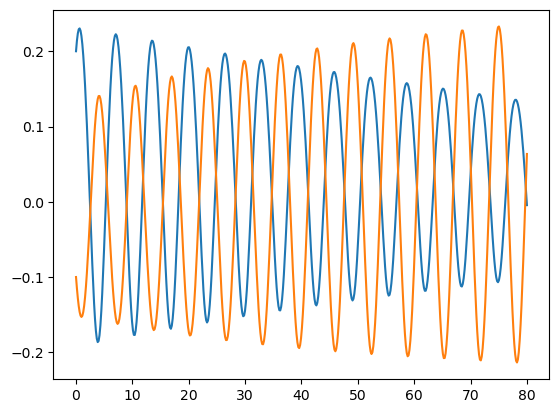

In [5]:
plt.plot(t_grid,q_values[:,0])
plt.plot(t_grid,q_values[:,1])

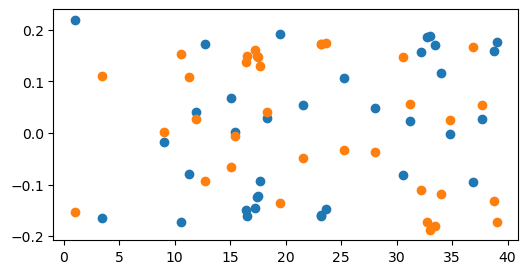

In [6]:
n_obs = 35
t_obs = jax.random.uniform(key(123),n_obs,minval =0., maxval = 40.)

eval_qp = lambda x:jnp.hstack(
        [
            sol.evaluate(x)['q'],
            sol.evaluate(x)['p'],
		]
            )

x_obs = jax.vmap(
    eval_qp
    )(t_obs)


plt.figure(figsize=(6,3))
plt.scatter(t_obs,x_obs[:,0],label = 'q1')
plt.scatter(t_obs,x_obs[:,1],label = 'q2')

In [7]:
from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant,CholDataAdaptedRKHSInterpolant,CholRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel,PolyLib
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from jsindy.optim import AnnealedAlternatingActiveSetLMSolver
from pysindy import STLSQ,SSR,MIOSR,PolynomialLibrary

polylib = PolyLib(degree = 2,include_interaction=True)

trajectory_model = CholDataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.,feature_map=polylib)
optsettings = LMSettings(
    max_iter = 1000,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
    print_every = 100,
)
data_weight =  1e3
n_colloc = 500
colloc_weight = 1e4
sparsifier = pySindySparsifier(
    STLSQ(threshold = 0.2,alpha = 0.1)
    )


optimizer = AnnealedAlternatingActiveSetLMSolver(
	beta_reg=1e-5,
	solver_settings=optsettings,
	fixed_colloc_weight=colloc_weight,
	fixed_data_weight=data_weight,
	sparsifier = sparsifier
	)
# optimizer = AlternatingActiveSetLMSolver(
#         beta_reg=1e-5,
#         solver_settings=optsettings,
#         fixed_colloc_weight=colloc_weight,
#         fixed_data_weight=data_weight,
#         sparsifier = sparsifier
#         )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=['q0','q1','p0','p1'],
    ode_order = 1
)

In [8]:
model.fit(t_obs,x_obs)
model.print()

{'show_progress': True, 'sigma2_est': Array(1.e-06, dtype=float64), 'data_weight': 1000.0, 'colloc_weight': 10000.0}
Solving for data_weight = 1000.0, colloc_weight = 80.0 beta_reg = 8e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 14.51, gradnorm = 62.27, alpha = 4.167, improvement_ratio = 1.001
Iteration 1, loss = 7.977, gradnorm = 27.14, alpha = 3.472, improvement_ratio = 1.013
Iteration 2, loss = 6.255, gradnorm = 5.14, alpha = 2.894, improvement_ratio = 1.018
Iteration 3, loss = 5.153, gradnorm = 2.619, alpha = 2.411, improvement_ratio = 1.013
Iteration 4, loss = 4.303, gradnorm = 1.921, alpha = 2.009, improvement_ratio = 1.009
Iteration 5, loss = 3.623, gradnorm = 1.545, alpha = 1.674, improvement_ratio = 1.007
Iteration 100, loss = 0.0007676, gradnorm = 0.0009453, alpha = 2.197e-05, improvement_ratio = 1.002
Iteration 112, loss = 0.0007652, gradnorm = 4.748e-09, alpha = 2.464e-06, improvement_ratio = 1.0
Solving for data_weight = 1000.0, colloc_weight = 400.0 beta_reg = 4e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 0.000778, gradnorm = 0.02202, alpha = 4.167, improvement_ratio = 1.0
Iteration 1, loss = 0.0007779, gradnorm = 0.0009, alpha = 3.472, improvement_ratio = 1.0
Iteration 2, loss = 0.0007779, gradnorm = 0.0004924, alpha = 2.894, improvement_ratio = 1.0
Iteration 3, loss = 0.0007779, gradnorm = 0.0003947, alpha = 2.411, improvement_ratio = 1.0
Iteration 4, loss = 0.0007778, gradnorm = 0.0003458, alpha = 2.009, improvement_ratio = 1.0
Iteration 5, loss = 0.0007778, gradnorm = 0.0003136, alpha = 1.674, improvement_ratio = 1.0
Iteration 72, loss = 0.0007695, gradnorm = 9.156e-09, alpha = 8.294e-06, improvement_ratio = 1.0
Solving for data_weight = 1000.0, colloc_weight = 2000.0 beta_reg = 2e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 0.0007769, gradnorm = 0.02767, alpha = 4.167, improvement_ratio = 1.0
Iteration 1, loss = 0.0007769, gradnorm = 0.0006656, alpha = 3.472, improvement_ratio = 1.0
Iteration 2, loss = 0.0007769, gradnorm = 0.0003644, alpha = 2.894, improvement_ratio = 1.0
Iteration 3, loss = 0.0007768, gradnorm = 0.0002977, alpha = 2.411, improvement_ratio = 1.0
Iteration 4, loss = 0.0007768, gradnorm = 0.0002594, alpha = 2.009, improvement_ratio = 1.0
Iteration 5, loss = 0.0007768, gradnorm = 0.0002299, alpha = 1.674, improvement_ratio = 1.0
Iteration 72, loss = 0.0007722, gradnorm = 7.629e-09, alpha = 8.294e-06, improvement_ratio = 1.0
Solving for data_weight = 1000.0, colloc_weight = 10000.0 beta_reg = 1e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 0.0007774, gradnorm = 0.0303, alpha = 4.167, improvement_ratio = 1.0
Iteration 1, loss = 0.0007774, gradnorm = 0.0005074, alpha = 3.472, improvement_ratio = 1.0
Iteration 2, loss = 0.0007774, gradnorm = 0.0002452, alpha = 2.894, improvement_ratio = 1.0
Iteration 3, loss = 0.0007774, gradnorm = 0.0001856, alpha = 2.411, improvement_ratio = 1.0
Iteration 4, loss = 0.0007774, gradnorm = 0.0001542, alpha = 2.009, improvement_ratio = 1.0
Iteration 5, loss = 0.0007774, gradnorm = 0.0001323, alpha = 1.674, improvement_ratio = 1.0
Iteration 72, loss = 0.0007741, gradnorm = 6.959e-09, alpha = 8.294e-06, improvement_ratio = 0.9998
Model after smooth warm start
(q0)' = 0.999 p0 + -0.002 p1 + 0.002 q0^2 + 0.028 q0 p0 + 0.045 q0 p1 + -0.007 q1^2 + 0.023 q1 p0 + 0.036 q1 p1 + -0.013 p0^2 + -0.020 p0 p1 + -0.009 p1^2
(q1)' = 1.001 p1 + -0.001 q0^2 + -0.005 q0 q1 + -0.004 q0 p0 + -0.011 q0 p1 + -0.002 q1 p0 + -0.008 q1 p1 + 0.006 p0^2 + 0.009 p0 p1 + 0.006 p1^2
(p0)' = -1.001 q0 + 

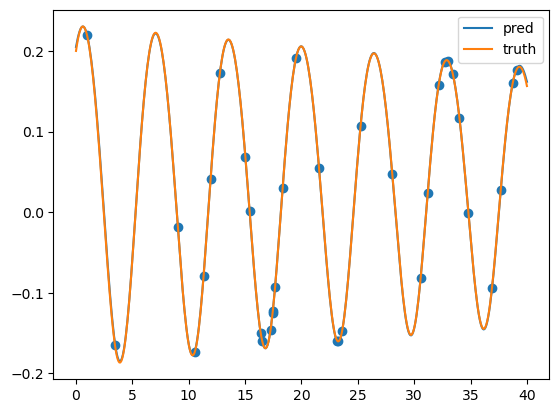

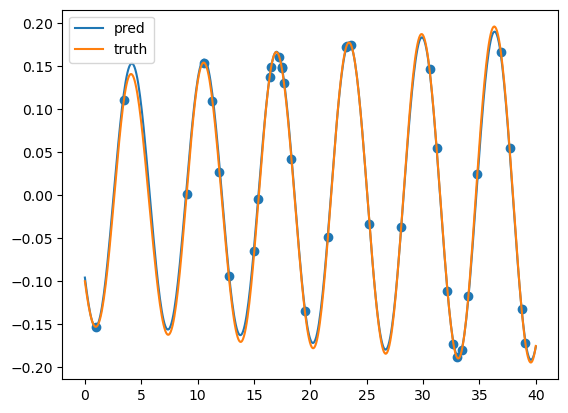

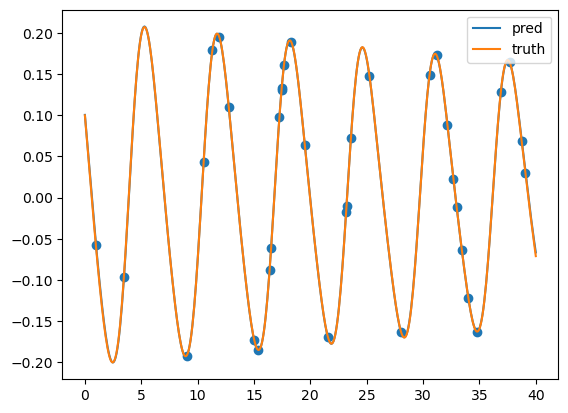

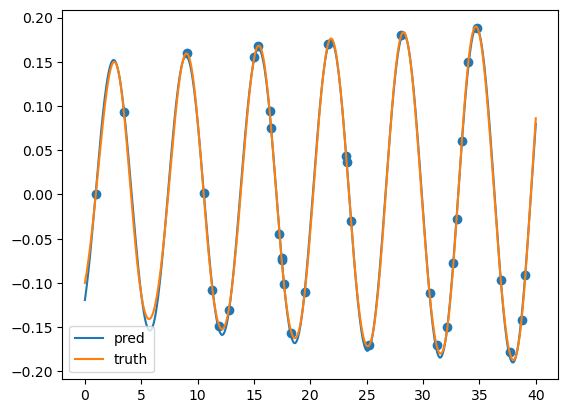

In [11]:
t_interp = jnp.linspace(0,40,500)
state_preds_interp = model.predict_state(t_interp)
true_states_interp = jax.vmap(eval_qp)(t_interp)

for i in range(4):
	plt.plot(t_interp,state_preds_interp[:,i],label = 'pred')
	plt.plot(t_interp,true_states_interp[:,i], label = 'truth')
	plt.scatter(t_obs,x_obs[:,i])
	plt.legend()
	plt.show()

In [12]:
print("Max datafit residual: ",jnp.max(jnp.abs(model.data_term.residual(model.z))))
print("Max colloc residual: ",jnp.max(jnp.abs(model.colloc_term.residual(model.z,model.theta))))

Max datafit residual:  0.008354246759793318
Max colloc residual:  0.0005648340114841611


In [13]:
print(jnp.linalg.norm(true_states_interp - state_preds_interp)/jnp.linalg.norm(true_states_interp))

0.0316040435299249


In [14]:
new_x0 = eval_qp(40.)

def model_ode(t,x,args=None):
	return model.predict(x)

dt0 = 0.0025
stepsize_controller = diffrax.PIDController(rtol = 1e-8,atol =1e-8)
save_at = diffrax.SaveAt(dense=True)

model_sol = diffrax.diffeqsolve(
	terms = diffrax.ODETerm(model_ode),
	solver = diffrax.Tsit5(),
	t0=40.,
	t1=80,
	dt0=dt0,
	y0=new_x0,
	saveat=save_at,
    stepsize_controller=stepsize_controller,
    max_steps = int(20 * (40/dt0)),
)


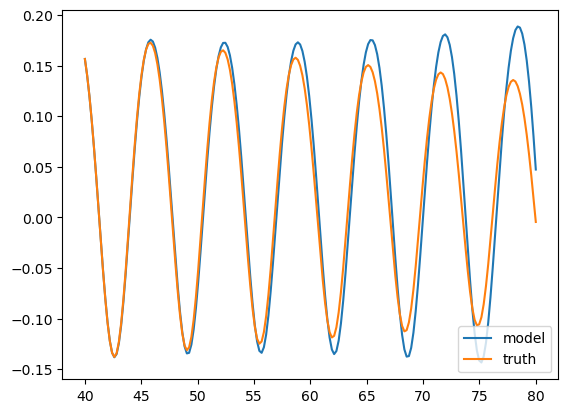

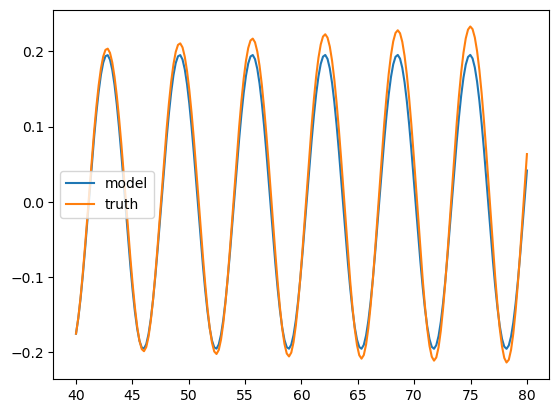

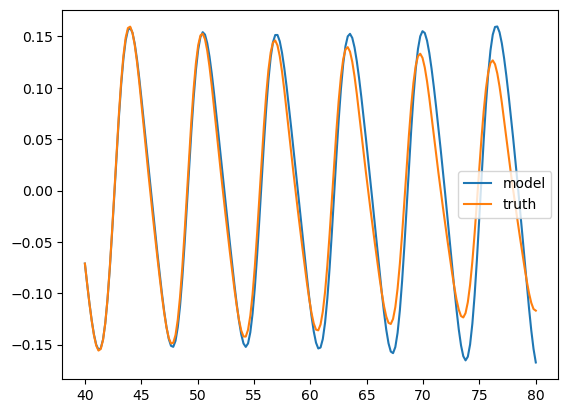

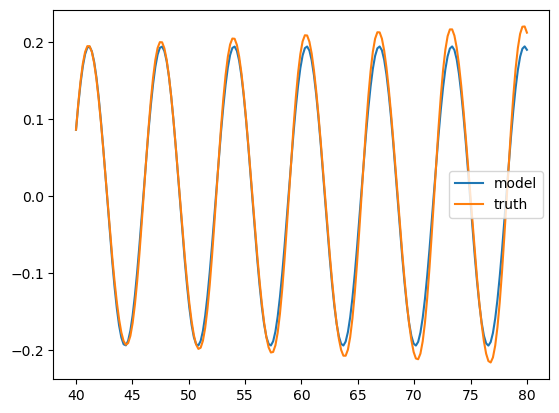

In [15]:
t_extrap = jnp.linspace(40,80,200)
x_extrap = jax.vmap(model_sol.evaluate)(t_extrap)

x_extrap_true = jax.vmap(eval_qp)(t_extrap)
for i in range(4):
    plt.plot(t_extrap,x_extrap[:,i],label = 'model')
    plt.plot(t_extrap,x_extrap_true[:,i],label = 'truth')
    plt.legend()
    plt.show()